In [107]:
import numpy as np
import pandas as pd
import string
import itertools
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

from gensim.models import *

import tensorflow as tf
from tensorflow.keras.utils import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [108]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [109]:
df = pd.read_csv("/content/drive/MyDrive/TrainData.csv")
df_test = pd.read_csv("/content/drive/MyDrive/TestData_Inputs.csv")
df_labels = pd.read_excel("/content/drive/MyDrive/Assignment4_TestLabels.xlsx", sheet_name=0, usecols = [0, 2], names = ['ArticleId', 'Category'])
#df_labels = pd.read_csv("/content/drive/MyDrive/DLNP Assignments/Assignment 4/Assignment4_TestLabels.xlsx")

In [133]:
text_len

0       1866
1       2016
2       3104
3       3618
4       2190
        ... 
1485    1266
1486    3111
1487    1370
1488    3242
1489    1723
Name: Text, Length: 1490, dtype: int64

In [110]:
type(df_labels)

pandas.core.frame.DataFrame

In [111]:
df.describe

<bound method NDFrame.describe of                                                    Text       Category
0     worldcom ex-boss launches defence lawyers defe...       business
1     german business confidence slides german busin...       business
2     bbc poll indicates economic gloom citizens in ...       business
3     lifestyle  governs mobile choice  faster  bett...           tech
4     enron bosses in $168m payout eighteen former e...       business
...                                                 ...            ...
1485  double eviction from big brother model caprice...  entertainment
1486  dj double act revamp chart show dj duo jk and ...  entertainment
1487  weak dollar hits reuters revenues at media gro...       business
1488  apple ipod family expands market apple has exp...           tech
1489  santy worm makes unwelcome visit thousands of ...           tech

[1490 rows x 2 columns]>

In [112]:
df_test.describe

<bound method NDFrame.describe of      ArticleId                                               Text
0         1018  qpr keeper day heads for preston queens park r...
1         1319  software watching while you work software that...
2         1138  d arcy injury adds to ireland woe gordon d arc...
3          459  india s reliance family feud heats up the ongo...
4         1020  boro suffer morrison injury blow middlesbrough...
..         ...                                                ...
730       1923  eu to probe alitalia  state aid  the european ...
731        373  u2 to play at grammy awards show irish rock ba...
732       1704  sport betting rules in spotlight a group of mp...
733        206  alfa romeos  to get gm engines  fiat is to sto...
734        471  citizenship event for 18s touted citizenship c...

[735 rows x 2 columns]>

Preprocessing of the data


In [134]:
df["Text"] = df["Text"].str.lower()

df_test["Text"] = df_test["Text"].str.lower()

In [135]:
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

df["Text"] = df["Text"].apply(lambda text: remove_punctuation(text))

df_test["Text"] = df_test["Text"].apply(lambda text: remove_punctuation(text))

In [136]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [137]:
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

df["Text"] = df["Text"].apply(lambda text: remove_stopwords(text))

df_test["Text"] = df_test["Text"].apply(lambda text: remove_stopwords(text))

In [138]:
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

df["Text"] = df["Text"].apply(lambda text: lemmatize_words(text))

df_test["Text"] = df_test["Text"].apply(lambda text: lemmatize_words(text))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [153]:
text_len = list()

text_len = (df["Text"]).str.split().str.len()
text_len

0       191
1       203
2       292
3       353
4       211
       ... 
1485    124
1486    314
1487    148
1488    327
1489    173
Name: Text, Length: 1490, dtype: int64

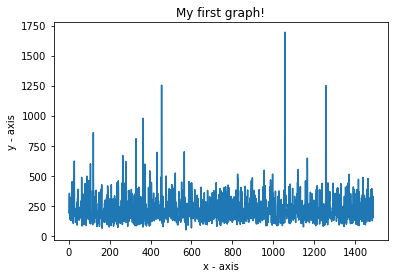

In [154]:
import matplotlib.pyplot as plt
x =  list(range(0, 1490))

plt.plot(x, text_len)
 
# naming the x axis
plt.xlabel('x - axis')
# naming the y axis
plt.ylabel('y - axis')
 
# giving a title to my graph
plt.title('My first graph!')
 
# function to show the plot
plt.show()

 

In [155]:
x = np.array(x)
x.shape

(1490,)

In [156]:
maxi =max(text_len)
maxi

1695

In [13]:
import gensim
import gensim.downloader

In [14]:
glove = gensim.downloader.load('glove-wiki-gigaword-300')

[==================================================] 100.0% 376.1/376.1MB downloaded


In [113]:
ft = gensim.downloader.load('fasttext-wiki-news-subwords-300')

[==================================================] 100.0% 958.5/958.4MB downloaded


In [214]:
max_len = 500
tokenizer = Tokenizer(lower=True)
tokenizer.fit_on_texts(df['Text'])

sequence_train = tokenizer.texts_to_sequences(df['Text'])
sequence_train = pad_sequences(sequence_train, maxlen=max_len)

sequence_test = tokenizer.texts_to_sequences(df_test['Text'])
sequence_test = pad_sequences(sequence_test, maxlen=max_len)

sequence_train = np.asarray(sequence_train)
sequence_test = np.asarray(sequence_test)

word_index = tokenizer.word_index
vocab_size = len(word_index)+1

print(vocab_size)
print(sequence_train.shape, sequence_test.shape)

24837
(1490, 500) (735, 500)


In [215]:
embedding_matrix_glove = np.random.random((len(tokenizer.word_index)+1, 300))

pas = 0
for word,i in tokenizer.word_index.items():
    
    try:
        embedding_matrix_glove[i] = glove.wv[word]
    except:
        pas+=1
        
print('not in vocabulary', pas)

not in vocabulary 3562


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  import sys


In [216]:
embedding_matrix_ft = np.random.random((len(tokenizer.word_index)+1 , 300))

pas = 0
for word,i in tokenizer.word_index.items():
    
    try:
        embedding_matrix_ft[i] = ft.wv[word]
    except:
        pas+=1
        
print('not in vocabulary', pas)

not in vocabulary 5766


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  import sys


In [217]:
df_labels['Category']

0              sport
1               tech
2              sport
3           business
4              sport
           ...      
730         business
731    entertainment
732            sport
733         business
734         politics
Name: Category, Length: 735, dtype: object

In [218]:
df.head()


,Text,Category,0,1,2,3,4
0,worldcom exboss launch defence lawyer defendin...,business,1.0,0.0,0.0,0.0,0.0
1,german business confidence slide german busine...,business,1.0,0.0,0.0,0.0,0.0
2,bbc poll indicates economic gloom citizen majo...,business,1.0,0.0,0.0,0.0,0.0
3,lifestyle governs mobile choice faster better ...,tech,0.0,0.0,0.0,0.0,1.0
4,enron boss 168m payout eighteen former enron d...,business,1.0,0.0,0.0,0.0,0.0


In [219]:
enc_df = pd.DataFrame(enc.fit_transform(df[['Category']]).toarray())

In [220]:
y_train_label = enc_df
y_train_label = y_train_label.to_numpy()

In [183]:
x_train = df['Text']

In [221]:
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix_glove], input_length=500, trainable=False)

model = Sequential()
model.add(embedding_layer)
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(64))
model.add(Flatten())
#model.add(Dense(20, activation='relu'))
model.add(Dense(5, activation='softmax'))
print(model.summary())

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_23 (Embedding)     (None, 500, 300)          7451100   
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 496, 128)          192128    
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 248, 128)          0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 64)                49408     
_________________________________________________________________
flatten_10 (Flatten)         (None, 64)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 5)                 325       
Total params: 7,692,961
Trainable params: 241,861
Non-trainable params: 7,451,100
_____________________________________

In [222]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [223]:
y_train_label.shape

(1490, 5)

In [224]:
model.fit(sequence_train, y_train_label, epochs=10, verbose=1, validation_split =0.15)

Epoch 1/10
40/40 [==============================] - 16s 363ms/step - loss: 0.6709 - accuracy: 0.7725 - val_loss: 0.2797 - val_accuracy: 0.9062
Epoch 2/10
40/40 [==============================] - 14s 351ms/step - loss: 0.1685 - accuracy: 0.9447 - val_loss: 0.2230 - val_accuracy: 0.9152
Epoch 3/10
40/40 [==============================] - 14s 350ms/step - loss: 0.1145 - accuracy: 0.9668 - val_loss: 0.1959 - val_accuracy: 0.9420
Epoch 4/10
40/40 [==============================] - 14s 349ms/step - loss: 0.1743 - accuracy: 0.9423 - val_loss: 0.2160 - val_accuracy: 0.9464
Epoch 5/10
40/40 [==============================] - 14s 349ms/step - loss: 0.0803 - accuracy: 0.9787 - val_loss: 0.2211 - val_accuracy: 0.9375
Epoch 6/10
40/40 [==============================] - 14s 351ms/step - loss: 0.0724 - accuracy: 0.9763 - val_loss: 0.1998 - val_accuracy: 0.9286
Epoch 7/10
40/40 [==============================] - 14s 349ms/step - loss: 0.0582 - accuracy: 0.9858 - val_loss: 0.1639 - val_accuracy: 0.9464

In [225]:
predictions = model.predict(sequence_test)
predictions

array([[5.6526245e-05, 1.0956049e-04, 4.9655273e-04, 9.9927360e-01,
        6.3685642e-05],
       [1.6227758e-02, 1.3525148e-03, 2.7154838e-03, 1.5306858e-04,
        9.7955120e-01],
       [4.9544258e-05, 1.7730556e-04, 6.5910438e-04, 9.9886692e-01,
        2.4714033e-04],
       ...,
       [1.8763101e-01, 3.2621235e-04, 3.5112843e-01, 1.4899173e-02,
        4.4601512e-01],
       [9.8261696e-01, 2.0905872e-04, 1.5990484e-03, 3.6372314e-03,
        1.1937709e-02],
       [1.5025440e-03, 2.7668040e-04, 9.9680787e-01, 4.3941452e-04,
        9.7341085e-04]], dtype=float32)

In [226]:
df_labels = pd.read_excel("/content/drive/MyDrive/Assignment4_TestLabels.xlsx", sheet_name=0, usecols = [0, 2], names = ['ArticleId', 'Category'])
df_labels

,ArticleId,Category
0,1018,sport
1,1319,tech
2,1138,sport
3,459,business
4,1020,sport
...,...,...
730,1923,business
731,373,entertainment
732,1704,sport
733,206,business


In [227]:
test_label = pd.DataFrame(enc.fit_transform(df_labels[['Category']]).toarray())

In [228]:
test_label

,0,1,2,3,4
0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...
730,1.0,0.0,0.0,0.0,0.0
731,0.0,1.0,0.0,0.0,0.0
732,0.0,0.0,0.0,1.0,0.0
733,1.0,0.0,0.0,0.0,0.0


In [229]:
predicted = []
for i in predictions:
  predicted.append(np.argmax(i))

predicted = np.array(predicted)
predicted

array([3, 4, 3, 0, 3, 3, 2, 2, 1, 0, 0, 4, 2, 4, 1, 3, 2, 4, 1, 1, 0, 2,
       3, 0, 2, 3, 0, 3, 3, 0, 2, 4, 0, 0, 3, 3, 3, 0, 1, 4, 4, 2, 1, 4,
       3, 4, 1, 0, 2, 0, 2, 0, 0, 0, 4, 2, 4, 1, 3, 4, 3, 1, 4, 2, 1, 1,
       3, 4, 3, 3, 4, 3, 0, 2, 4, 3, 4, 4, 4, 1, 2, 3, 1, 1, 0, 1, 0, 1,
       0, 4, 2, 2, 3, 4, 3, 3, 3, 3, 3, 3, 2, 3, 0, 1, 0, 3, 2, 3, 2, 1,
       3, 0, 1, 3, 2, 3, 2, 3, 2, 0, 1, 0, 1, 1, 4, 3, 0, 1, 0, 1, 0, 2,
       2, 4, 0, 0, 2, 4, 1, 3, 0, 4, 3, 1, 0, 3, 3, 1, 1, 4, 0, 4, 2, 4,
       3, 3, 3, 3, 1, 4, 0, 4, 0, 4, 0, 4, 1, 4, 4, 2, 0, 2, 0, 0, 1, 2,
       4, 0, 0, 4, 3, 2, 3, 2, 4, 4, 2, 0, 2, 4, 2, 0, 1, 3, 4, 4, 0, 4,
       2, 0, 3, 2, 0, 1, 0, 0, 3, 4, 0, 3, 1, 1, 3, 1, 3, 4, 2, 1, 3, 1,
       3, 1, 2, 2, 4, 1, 0, 2, 0, 4, 0, 3, 2, 2, 0, 2, 3, 0, 4, 2, 3, 2,
       0, 3, 4, 4, 2, 0, 2, 0, 0, 3, 4, 2, 1, 4, 1, 4, 3, 3, 4, 3, 3, 3,
       1, 3, 2, 4, 0, 3, 0, 3, 0, 3, 1, 0, 0, 1, 2, 0, 3, 3, 4, 3, 3, 1,
       0, 3, 4, 2, 1, 0, 0, 2, 3, 1, 4, 0, 3, 3, 4,

In [230]:
import sklearn.preprocessing
label_binarizer = sklearn.preprocessing.LabelBinarizer()
label_binarizer.fit(range(max(predicted)+1))
predicted = label_binarizer.transform(predicted)
print(predicted)

[[0 0 0 1 0]
 [0 0 0 0 1]
 [0 0 0 1 0]
 ...
 [0 0 0 0 1]
 [1 0 0 0 0]
 [0 0 1 0 0]]


In [231]:
predicted.shape

(735, 5)

In [232]:
test_loss, test_acc = model.evaluate(sequence_test, test_label)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

23/23 [==============================] - 3s 113ms/step - loss: 0.1708 - accuracy: 0.9578
Test Loss: 0.17077703773975372
Test Accuracy: 0.9578231573104858


In [233]:
from sklearn import metrics
metrics.f1_score(test_label, predicted, average='macro')

0.9575918171632573

**Dynamic Meta Embedding**

In [244]:
 
def Concat_Emb(list_emb, maxlen):
    
    inputs = []
    output = []
    inp = Input(shape=(maxlen,))
    inputs.append(inp)
    for embedding in list_emb:
        
        
        emb = Embedding(len(tokenizer.word_index)+1 , 300, weights=[embedding], trainable=False)(inp)
        emb = Reshape((-1,300,1))(emb)
        
        output.append(emb)
        
    concat = Concatenate(axis=-1)(output)
    
    return Model(inputs, concat)

In [245]:
read_emb = Concat_Emb([embedding_matrix_ft , embedding_matrix_glove], maxlen=max_len)
read_emb.summary()

Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding_28 (Embedding)        (None, 500, 300)     7451100     input_13[0][0]                   
__________________________________________________________________________________________________
embedding_29 (Embedding)        (None, 500, 300)     7451100     input_13[0][0]                   
__________________________________________________________________________________________________
reshape_24 (Reshape)            (None, 500, 300, 1)  0           embedding_28[0][0]               
___________________________________________________________________________________________

In [246]:
es = 300
n = 2
def DME(maxlen):

    inp = Input(shape=(maxlen, es, n))
    x = Reshape((maxlen, es*n))(inp)
    temp = Dense(es*n , activation = None)(x)
    proj2mul = Reshape((maxlen , es , n))(temp)
    proj = Permute((1 , 3 , 2 ))(proj2mul)
    alphas = Dense(1 , activation = None)(proj)
    alphas = Activation('softmax')(alphas)
    alphas2mul = Permute((1 , 3, 2))(alphas)
    x = multiply([proj2mul , alphas2mul])
    out = Lambda(lambda t: K.sum(t, axis=-1))(x)
    print('Out' , out.shape)
    return Model(inp, out)


In [247]:
concat_inp = Concat_Emb([embedding_matrix_ft , embedding_matrix_glove], maxlen=max_len)
dme = DME(max_len)
x = dme(concat_inp.output)
x = Conv1D(filters=128, kernel_size=5, activation='relu')(x)
x = MaxPooling1D(pool_size=2)(x)
x = LSTM(128, dropout=0.2, return_sequences=True)(x)
x = LSTM(32, dropout=0.2)(x)
out = Dense(5, activation='softmax')(x)

dme_model = Model(concat_inp.input, out)
dme_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

dme_model.summary()

Out (None, 500, 300)
Model: "model_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding_30 (Embedding)        (None, 500, 300)     7451100     input_14[0][0]                   
__________________________________________________________________________________________________
embedding_31 (Embedding)        (None, 500, 300)     7451100     input_14[0][0]                   
__________________________________________________________________________________________________
reshape_26 (Reshape)            (None, 500, 300, 1)  0           embedding_30[0][0]               
______________________________________________________________________

In [248]:
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience= 3)
dme_model.fit(sequence_train, y_train_label, batch_size=32, epochs=20, verbose=1, validation_split=0.2 , callbacks=[callback])

Epoch 1/20
38/38 [==============================] - 51s 1s/step - loss: 0.7885 - accuracy: 0.7416 - val_loss: 0.3282 - val_accuracy: 0.9027
Epoch 2/20
38/38 [==============================] - 48s 1s/step - loss: 0.2521 - accuracy: 0.9304 - val_loss: 0.2746 - val_accuracy: 0.9161
Epoch 3/20
38/38 [==============================] - 48s 1s/step - loss: 0.2334 - accuracy: 0.9362 - val_loss: 0.1753 - val_accuracy: 0.9530
Epoch 4/20
38/38 [==============================] - 48s 1s/step - loss: 0.1257 - accuracy: 0.9673 - val_loss: 0.1653 - val_accuracy: 0.9530
Epoch 5/20
38/38 [==============================] - 48s 1s/step - loss: 0.1335 - accuracy: 0.9589 - val_loss: 0.1905 - val_accuracy: 0.9497
Epoch 6/20
38/38 [==============================] - 48s 1s/step - loss: 0.1251 - accuracy: 0.9622 - val_loss: 0.1217 - val_accuracy: 0.9564
Epoch 7/20
38/38 [==============================] - 48s 1s/step - loss: 0.1072 - accuracy: 0.9673 - val_loss: 0.1872 - val_accuracy: 0.9396
Epoch 8/20
38/38 [==

In [249]:
test_loss, test_acc = dme_model.evaluate(sequence_test, test_label)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

23/23 [==============================] - 11s 429ms/step - loss: 0.1892 - accuracy: 0.9469
Test Loss: 0.18916213512420654
Test Accuracy: 0.9469387531280518


In [250]:
predictions = dme_model.predict(sequence_test)
predictions

array([[3.4577393e-03, 1.5613920e-02, 7.9456894e-03, 9.7078800e-01,
        2.1946128e-03],
       [6.4016722e-02, 1.1313305e-02, 1.1968667e-02, 5.8176147e-04,
        9.1211951e-01],
       [3.0592218e-04, 1.0430170e-03, 2.3554298e-03, 9.9554718e-01,
        7.4844621e-04],
       ...,
       [4.2016464e-01, 3.7357602e-03, 9.6887939e-02, 2.5333904e-03,
        4.7667822e-01],
       [9.9359798e-01, 1.1921787e-03, 2.3919668e-03, 1.0231412e-03,
        1.7947468e-03],
       [3.3974189e-02, 1.2709067e-02, 9.4309551e-01, 9.0631107e-03,
        1.1582236e-03]], dtype=float32)

In [251]:
predicted_dme = []
for i in predictions:
  predicted_dme.append(np.argmax(i))

predicted_dme = np.array(predicted_dme)
predicted_dme

array([3, 4, 3, 0, 3, 3, 2, 2, 1, 0, 0, 4, 2, 4, 1, 3, 2, 4, 1, 1, 0, 2,
       3, 0, 2, 3, 0, 3, 3, 0, 2, 4, 0, 0, 3, 3, 3, 0, 1, 1, 1, 2, 1, 4,
       3, 4, 1, 0, 2, 0, 2, 0, 0, 0, 4, 0, 4, 1, 3, 4, 3, 1, 4, 2, 1, 1,
       3, 4, 3, 3, 4, 3, 0, 2, 4, 3, 4, 4, 4, 1, 2, 3, 1, 1, 0, 1, 0, 1,
       0, 4, 2, 2, 3, 4, 3, 3, 3, 3, 3, 3, 2, 3, 0, 1, 0, 3, 2, 3, 2, 1,
       3, 0, 1, 3, 2, 3, 2, 3, 2, 0, 1, 0, 1, 1, 4, 3, 0, 1, 0, 1, 0, 2,
       2, 4, 0, 0, 2, 4, 1, 3, 0, 4, 3, 1, 0, 3, 3, 1, 1, 4, 0, 4, 2, 4,
       3, 3, 3, 3, 1, 4, 0, 4, 0, 4, 0, 4, 1, 4, 4, 2, 0, 2, 0, 0, 1, 2,
       4, 0, 0, 4, 3, 2, 3, 2, 4, 1, 2, 0, 2, 1, 2, 0, 1, 3, 4, 4, 0, 4,
       2, 0, 3, 2, 0, 1, 0, 0, 3, 4, 0, 3, 1, 1, 3, 1, 3, 4, 2, 1, 3, 1,
       3, 1, 2, 2, 4, 1, 0, 2, 0, 4, 0, 3, 2, 2, 0, 0, 3, 0, 0, 2, 3, 2,
       0, 3, 4, 0, 2, 0, 2, 0, 0, 3, 4, 2, 1, 4, 1, 4, 3, 3, 4, 3, 3, 3,
       1, 3, 2, 4, 0, 3, 0, 3, 0, 3, 1, 0, 0, 1, 2, 0, 3, 3, 4, 3, 3, 1,
       0, 3, 4, 2, 1, 0, 0, 2, 3, 1, 0, 0, 3, 3, 4,

In [252]:
label_binarizer = sklearn.preprocessing.LabelBinarizer()
label_binarizer.fit(range(max(predicted_dme)+1))
predicted_dme = label_binarizer.transform(predicted_dme)
print(predicted_dme)

[[0 0 0 1 0]
 [0 0 0 0 1]
 [0 0 0 1 0]
 ...
 [0 0 0 0 1]
 [1 0 0 0 0]
 [0 0 1 0 0]]


In [253]:
metrics.f1_score(test_label, predicted_dme, average='macro')

0.9474367293083701